In [47]:
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.tools.visualization import plot_histogram
from qiskit import Aer, transpile

import numpy as np
import matplotlib.pyplot as plt

simulator = Aer.get_backend('aer_simulator', device="GPU")

# using tikzplotlib to export plot to latex
import tikzplotlib

def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

def save_fig(name, width='10cm', height='10cm'):
    fig = plt.gcf()
    tikzplotlib_fix_ncols(fig)

    tikzplotlib.clean_figure()
    tikzplotlib.save(name + '.tex', axis_width=width, axis_height=height)

Mise en place des paramétres

In [48]:
nqubits = 3
train_depth = 3
time_steps = 0.77

Points d'entrainements

In [49]:
## Take number_x_train points from [x_min, x_max] randomly and use them as the training data.
x_min = - 1.; x_max = 1.
num_x_train = 15

## The 1-variable function we want to learn
func_to_learn = lambda x: np.sin(x*np.pi)
# func_to_learn = lambda x: np.exp(-(x*3)**2)

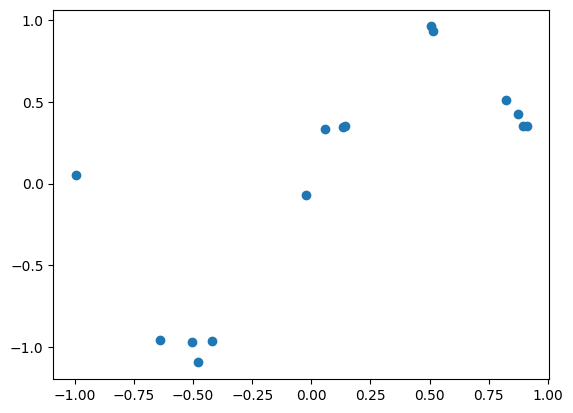

In [50]:
#### Prepare training data

train_x = x_min + (x_max - x_min) * np.random.rand(num_x_train)
train_y = func_to_learn(train_x)

# Add noise to a clean sin function
mag_noise = 0.05
train_y = train_y + mag_noise * np.random.randn(num_x_train)

y_min = min(train_y)
y_max = max(train_y)

amp_y = y_max - y_min

plt.plot(train_x, train_y, "o")
plt.show()

État de départ

In [51]:
def U_in(x):
    qc = QuantumCircuit(nqubits)
    angle_y = np.arcsin(x)
    angle_z = np.arccos(x**2)
    for i in range(nqubits):
        qc.ry(angle_y, i)
        qc.rz(angle_z, i)
    return qc

État parmétrique

In [52]:
# Import the matrix X, I, and Z gates from the qiskit library
from functools import reduce

X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.array([[1, 0], [0, 1]])

def make_fullgate(list_SiteAndOperator, nqubit):
    '''
    Receive list_SiteAndOperator = [ [i_0, O_0], [i_1, O_1], ...] ,
    insert Identity into irrelevent qubit, and create (2**nqubit, 2**nqubit) size matrix
    I(0) * ... * O_0(i_0) * ... * O_1(i_1) ...
    '''    
    list_Site = [SiteAndOperator[0] for SiteAndOperator in list_SiteAndOperator]
    list_SingleGates = []  ## list single 1-qubit gates and reduce them using np.kron
    cnt = 0
    for i in range(nqubit):
        if (i in list_Site):
            list_SingleGates.append( list_SiteAndOperator[cnt][1] )
            cnt += 1
        else: ## insert identity if i is not included in list_Site
            list_SingleGates.append(I)

    return reduce(np.kron, list_SingleGates)

ham = np.zeros((2**nqubits,2**nqubits), dtype = complex)
for i in range(nqubits): ## i runs 0 to nqubit-1
    Jx = -1. + 2.*np.random.rand() ## random number between -1~1
    ham += Jx * make_fullgate( [ [i, X] ], nqubits)
    for j in range(i+1, nqubits):
        J_ij = -1. + 2.*np.random.rand()
        ham += J_ij * make_fullgate ([ [i, Z], [j, Z]], nqubits)

## Create a time evolution operator by diagonalizing.  H*P = P*D <-> H = P*D*P^dagger
diag, eigen_vecs = np.linalg.eigh(ham)
time_evol_op = np.dot(np.dot(eigen_vecs, np.diag(np.exp(-1j*time_steps*diag))), eigen_vecs.T.conj()) # e^-iHT

In [53]:
time_evol_op.shape

(8, 8)

In [54]:
# convert time_evol_op to a qiskit operator
from qiskit.quantum_info import Operator
time_evol_op = Operator(time_evol_op)
evolve = QuantumCircuit(nqubits)
evolve.unitary(time_evol_op, range(nqubits))
print(evolve.draw('latex_source'))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=1.0em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \multigate{2}{\mathrm{Unitary}}_<<<{0} & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \ghost{\mathrm{Unitary}}_<<<{1} & \qw & \qw\\
	 	\nghost{{q}_{2} :  } & \lstick{{q}_{2} :  } & \ghost{\mathrm{Unitary}}_<<<{2} & \qw & \qw\\
\\ }}
\end{document}


In [55]:
U_rot = QuantumCircuit(nqubits)
# Create 3*nqubits parameters for the rotation gates rx, rz, rx on each qubit for U_rot
params = [Parameter('θ'+str(i)) for i in range(3*nqubits)]
for i in range(nqubits):
    U_rot.rx(params[i], i)
    U_rot.rz(params[i+nqubits], i)
    U_rot.rx(params[i+2*nqubits], i)
print(U_rot.draw('latex_source')) 

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \gate{\mathrm{R_X}\,(\mathrm{{\ensuremath{\theta}}0})} & \gate{\mathrm{R_Z}\,(\mathrm{{\ensuremath{\theta}}3})} & \gate{\mathrm{R_X}\,(\mathrm{{\ensuremath{\theta}}6})} & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \gate{\mathrm{R_X}\,(\mathrm{{\ensuremath{\theta}}1})} & \gate{\mathrm{R_Z}\,(\mathrm{{\ensuremath{\theta}}4})} & \gate{\mathrm{R_X}\,(\mathrm{{\ensuremath{\theta}}7})} & \qw & \qw\\
	 	\nghost{{q}_{2} :  } & \lstick{{q}_{2} :  } & \gate{\mathrm{R_X}\,(\mathrm{{\ensuremath{\theta}}2})} & \gate{\mathrm{R_Z}\,(\mathrm{{\ensuremath{\theta}}5})} & \gate{\mathrm{R_X}\,(\mathrm{{\ensuremath{\theta}}8})} & \qw & \qw\\
\\ }}
\end{document}


In [56]:
def U_out(parmameters):
    qc = QuantumCircuit(nqubits)
    for c in range(train_depth):
        qc.compose(evolve, inplace=True)
        rot_gate = U_rot.bind_parameters({params[i]: parmameters[3*c*nqubits + i] for i in range(3*nqubits)})
        qc.compose(rot_gate, inplace=True)
    return qc

Mesure

In [57]:
def circ_meas(qc):
    qc.measure_all()
    qc = transpile(qc, simulator)
    counts = simulator.run(qc).result().get_counts()
    tot_counts = sum(counts.values())
    zero_state = 0
    for key in counts:
        if key[0] == '0':
            zero_state += counts[key]
    expected = zero_state/tot_counts
    return expected*amp_y + y_min

Circuit complet

In [58]:
def complete_circuit(x, *parameters):
    qc = QuantumCircuit(nqubits)
    qc.compose(U_in(x), inplace=True)
    qc.compose(U_out(*parameters), inplace=True)
    return circ_meas(qc)

In [59]:
# Create a set of initial parameters
initial_parameters = np.random.rand(train_depth, 3*nqubits)*2*np.pi
initial_parameters = initial_parameters.flatten()
initial_parameters.shape

(27,)

In [60]:
print(U_out(initial_parameters).draw('latex_source'))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \multigate{2}{\mathrm{Unitary}}_<<<{0} & \gate{\mathrm{R_X}\,(\mathrm{2.403})} & \gate{\mathrm{R_Z}\,(\mathrm{5.414})} & \gate{\mathrm{R_X}\,(\mathrm{1.948})} & \multigate{2}{\mathrm{Unitary}}_<<<{0} & \gate{\mathrm{R_X}\,(\mathrm{4.838})} & \gate{\mathrm{R_Z}\,(\mathrm{3.738})} & \gate{\mathrm{R_X}\,(\mathrm{2.826})} & \multigate{2}{\mathrm{Unitary}}_<<<{0} & \gate{\mathrm{R_X}\,(\mathrm{5.467})} & \gate{\mathrm{R_Z}\,(\mathrm{0.8092})} & \gate{\mathrm{R_X}\,(\mathrm{0.2784})} & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \ghost{\mathrm{Unitary}}_<<<{1} & \gate{\mathrm{R_X}\,(\mathrm{2.446})} & \gate{\mathrm{R_Z}\,(\mathrm{1.276})} & \gate{\mathrm{R_X}\,(\mathrm{1.475})} & \ghost{\mathrm{Unitary}}_<<<{1} & \gate{\mathrm{R_X}\,(\mathrm{5.049})} & \gate{\mat

C:\Users\romai\AppData\Local\Temp\ipykernel_9304\869448860.py:5: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  rot_gate = U_rot.bind_parameters({params[i]: parmameters[3*c*nqubits + i] for i in range(3*nqubits)})


In [61]:
complete_circuit(1, initial_parameters)

C:\Users\romai\AppData\Local\Temp\ipykernel_9304\869448860.py:5: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  rot_gate = U_rot.bind_parameters({params[i]: parmameters[3*c*nqubits + i] for i in range(3*nqubits)})


0.2209217576480056

Cost

In [62]:
def cost_function(parameters):
    tot = []
    x = train_x
    y = train_y
    for i in range(len(x)):
        expected = complete_circuit(x[i], parameters)
        cost = (expected - y[i])**2
        tot.append(cost)
    return np.mean(tot)

In [63]:
cost_function(initial_parameters)

C:\Users\romai\AppData\Local\Temp\ipykernel_9304\869448860.py:5: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  rot_gate = U_rot.bind_parameters({params[i]: parmameters[3*c*nqubits + i] for i in range(3*nqubits)})


0.9116426558042666

C:\Users\romai\AppData\Local\Temp\ipykernel_9304\869448860.py:5: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  rot_gate = U_rot.bind_parameters({params[i]: parmameters[3*c*nqubits + i] for i in range(3*nqubits)})


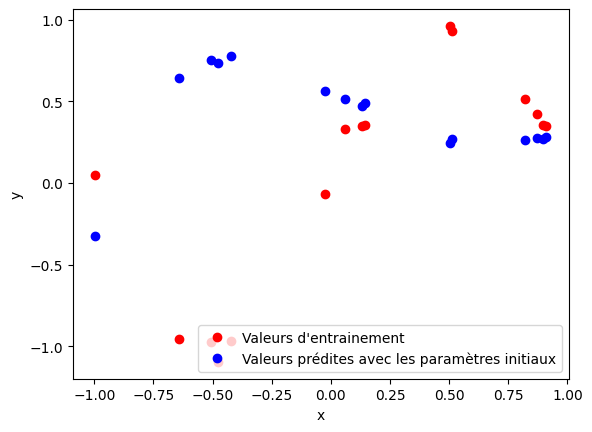

In [72]:
plt.plot(train_x, train_y, 'ro', label="Valeurs d'entrainement")
plt.plot(train_x, [complete_circuit(x, initial_parameters) for x in train_x], 'bo', label="Valeurs prédites avec les paramètres initiaux")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="lower right")
save_fig("initial_predictions")

Entrainement

Tests

Descente de gradient

In [65]:
def grad_cost_function(depth, step):
    int_cost = []
    opt_param = initial_parameters.copy()
    prev_cost = cost_function(opt_param)
    for _ in range(depth):
        for i in range(3*nqubits*train_depth):
            opt_param[i] += step
            c1 = cost_function(opt_param)
            opt_param[i] -= 2*step
            c2 = cost_function(opt_param)
            if prev_cost < c1 and prev_cost < c2:
                opt_param[i] += step
                int_cost.append(prev_cost)
            elif c1 < c2:
                opt_param[i] += 2*step
                int_cost.append(c1)
                prev_cost = c1
            else:
                int_cost.append(c2)
                prev_cost = c2
    
    return (int_cost, opt_param)

In [66]:
example_desc, example_opt = grad_cost_function(20, 0.1)

C:\Users\romai\AppData\Local\Temp\ipykernel_9304\869448860.py:5: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  rot_gate = U_rot.bind_parameters({params[i]: parmameters[3*c*nqubits + i] for i in range(3*nqubits)})


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


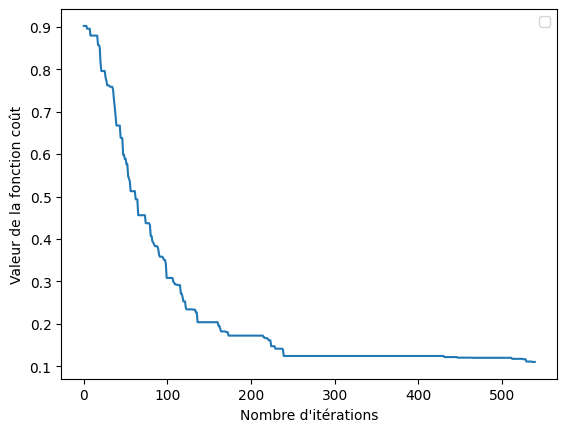

In [67]:
plt.plot(example_desc)
plt.xlabel("Nombre d'itérations")
plt.ylabel("Valeur de la fonction coût")
plt.legend()
save_fig("gradient_descent")

C:\Users\romai\AppData\Local\Temp\ipykernel_9304\869448860.py:5: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  rot_gate = U_rot.bind_parameters({params[i]: parmameters[3*c*nqubits + i] for i in range(3*nqubits)})


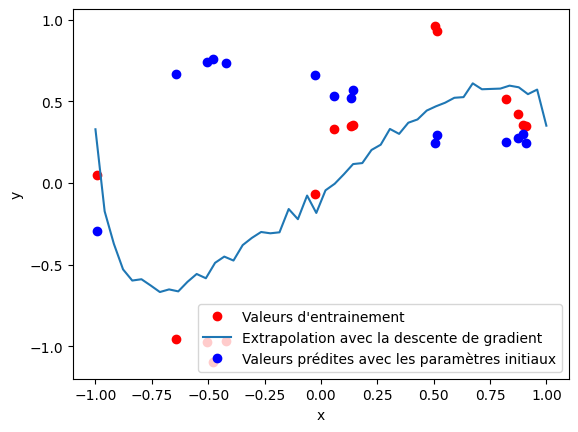

In [68]:
plt.plot(train_x, train_y, 'ro', label="Valeurs d'entrainement")
plt.plot(np.linspace(-1,1), [complete_circuit(x, example_opt) for x in np.linspace(-1,1)], '-', label="Extrapolation avec la descente de gradient")
plt.plot(train_x, [complete_circuit(x, initial_parameters) for x in train_x], 'bo', label="Valeurs prédites avec les paramètres initiaux")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
save_fig("extrapolation_gradient_descent")

In [69]:
print(U_out(example_opt).draw('latex_source'))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \multigate{2}{\mathrm{Unitary}}_<<<{0} & \gate{\mathrm{R_X}\,(\mathrm{2.603})} & \gate{\mathrm{R_Z}\,(\mathrm{5.414})} & \gate{\mathrm{R_X}\,(\mathrm{1.948})} & \multigate{2}{\mathrm{Unitary}}_<<<{0} & \gate{\mathrm{R_X}\,(\mathrm{4.738})} & \gate{\mathrm{R_Z}\,(\mathrm{3.538})} & \gate{\mathrm{R_X}\,(\mathrm{2.526})} & \multigate{2}{\mathrm{Unitary}}_<<<{0} & \gate{\mathrm{R_X}\,(\mathrm{5.667})} & \gate{\mathrm{R_Z}\,(\mathrm{0.9092})} & \gate{\mathrm{R_X}\,(\mathrm{0.4784})} & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \ghost{\mathrm{Unitary}}_<<<{1} & \gate{\mathrm{R_X}\,(\mathrm{3.146})} & \gate{\mathrm{R_Z}\,(\mathrm{1.276})} & \gate{\mathrm{R_X}\,(\mathrm{1.375})} & \ghost{\mathrm{Unitary}}_<<<{1} & \gate{\mathrm{R_X}\,(\mathrm{4.949})} & \gate{\mat

C:\Users\romai\AppData\Local\Temp\ipykernel_9304\869448860.py:5: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  rot_gate = U_rot.bind_parameters({params[i]: parmameters[3*c*nqubits + i] for i in range(3*nqubits)})


In [76]:
qc_draw = QuantumCircuit(nqubits,1)

angle_y = Parameter('arcsin(x)')
angle_z = Parameter('arccos(x^2)')
for i in range(nqubits):
        qc_draw.ry(angle_y, i)
        qc_draw.rz(angle_z, i)

qc_draw.barrier()

for c in range(train_depth):
        qc_draw.compose(evolve, inplace=True)
        qc_draw.compose(U_rot, inplace=True)

qc_draw.barrier()

qc_draw.measure(0,0)

print(qc_draw.draw('latex_source'))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \gate{\mathrm{R_Y}\,(\mathrm{arcsin(x)})} & \gate{\mathrm{R_Z}\,(\mathrm{arccos(x^2)})} \barrier[0em]{2} & \qw & \multigate{2}{\mathrm{Unitary}}_<<<{0} & \gate{\mathrm{R_X}\,(\mathrm{{\ensuremath{\theta}}0})} & \gate{\mathrm{R_Z}\,(\mathrm{{\ensuremath{\theta}}3})} & \gate{\mathrm{R_X}\,(\mathrm{{\ensuremath{\theta}}6})} & \multigate{2}{\mathrm{Unitary}}_<<<{0} & \gate{\mathrm{R_X}\,(\mathrm{{\ensuremath{\theta}}0})} & \gate{\mathrm{R_Z}\,(\mathrm{{\ensuremath{\theta}}3})} & \gate{\mathrm{R_X}\,(\mathrm{{\ensuremath{\theta}}6})} & \multigate{2}{\mathrm{Unitary}}_<<<{0} & \gate{\mathrm{R_X}\,(\mathrm{{\ensuremath{\theta}}0})} & \gate{\mathrm{R_Z}\,(\mathrm{{\ensuremath{\theta}}3})} & \gate{\mathrm{R_X}\,(\mathrm{{\ensuremath{\theta}}6})} \barrier[0em]{2} & \qw & \meter & \qw

c:\Python310\lib\site-packages\qiskit\visualization\circuit\latex.py:154: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, _ = load_style(style)
